In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from result_analysis.load_model import load_model
from eval_utils.rotation_utils import QKRotationWrapper
from utils.quant_utils import ActQuantWrapper, ActQuantizer

print("Current working directory:", os.getcwd())

os.environ['CUDA_VISIBLE_DEVICE']="2"

Importing quant utils. ZP_INT8: 0, SIGNED_KV: 0, ZP_CLAMP: 1, SCALE_NO_UPCAST: 0
Current working directory: /home/jaeyongjang/project.local/SpinQuant/result_analysis


In [2]:
# Load Model
print("Loading model...")
model, tokenizer = load_model(
    input_model="../models/llama2-7b",
    load_qmodel_path="../saved_models/llama2-7b/a16w4kv4-vasym.pt",
    optimized_rotation_path="../rotation_llama-2-7b/a16w4kv4-vsym/R.bin",
    w_bits=4,
    a_bits=16,
    k_bits=4,
    v_bits=4,
    k_groupsize=128,
    v_groupsize=128,
    w_clip=True,
    a_asym=True,
    k_asym=True,
    v_asym=True,
    rotate=True
)
model.eval()

2025-12-16 14:21:40,166 - spinquant - INFO - Loading model with args: ['python', '--input_model', '../models/llama2-7b', '--do_train', 'False', '--do_eval', 'True', '--per_device_eval_batch_size', '4', '--model_max_length', '2048', '--fp16', 'True', '--bf16', 'False', '--save_safetensors', 'False', '--w_bits', '4', '--a_bits', '16', '--k_bits', '4', '--v_bits', '4', '--k_groupsize', '128', '--v_groupsize', '128', '--w_clip', '--a_asym', '--k_asym', '--v_asym', '--rotate', '--load_qmodel_path', '../saved_models/llama2-7b/a16w4kv4-vasym.pt', '--optimized_rotation_path', '../rotation_llama-2-7b/a16w4kv4-vsym/R.bin']
2025-12-16 14:21:40,289 - spinquant - INFO - ------- ARGS ----------
2025-12-16 14:21:40,291 - spinquant - INFO - -----model args-----
2025-12-16 14:21:40,292 - spinquant - INFO - ModelArguments(input_model='../models/llama2-7b', output_rotation_path='test-output', optimized_rotation_path='../rotation_llama-2-7b/a16w4kv4-vsym/R.bin', access_token=None)
2025-12-16 14:21:40,292 

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jaeyongjang/.conda/envs/spinquant/lib/python3.10/site-packages/transformers/modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Load quantized model from  ../saved_models/llama2-7b/a16w4kv4-vasym.pt


2025-12-16 14:24:55,177 - spinquant - INFO - Model PTQ completed LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=409

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQua

In [3]:
# Load Quantizers for Weights
# We need to load the save_dict manually to get w_quantizers
load_qmodel_path = "../saved_models/llama2-7b/a16w4kv4-vasym.pt"
print(f"Loading quantizers from {load_qmodel_path}...")
save_dict = torch.load(load_qmodel_path, map_location="cpu", weights_only=False)
w_quantizers = save_dict.get("w_quantizers", {})

if not w_quantizers:
    print("Warning: No w_quantizers found in checkpoint. Weight analysis might be incorrect if weights are not fake-quantized.")
else:
    print(f"Found {len(w_quantizers)} weight quantizers.")

Loading quantizers from ../saved_models/llama2-7b/a16w4kv4-vasym.pt...
Found 224 weight quantizers.


In [6]:
# Analyze Weights (Int4) for Layer 0 - Row-wise Analysis
print("Analyzing Layer 0 Weights (Int4) - Row-wise...")

import seaborn as sns

# Iterate over modules in layer 0
layer0 = model.model.layers[0]

# Helper to process linear layers
def get_int_weight(name, module):
    # Find corresponding quantizer
    # The keys in w_quantizers are like 'model.layers.0.self_attn.q_proj'
    full_name = f"model.layers.0.{name}.module"
    
    if full_name in w_quantizers:
        quantizer = w_quantizers[full_name]
        weight = module.weight.data.to(quantizer.scale.device) # Fake quantized weight
        
        scale = quantizer.scale.to(weight.device)
        zero = quantizer.zero.to(weight.device)
        
        # Avoid division by zero
        scale = scale + 1e-9
        
        w_int = (weight / scale) + zero
        w_int = torch.round(w_int)
        return w_int.cpu()
    else:
        print(f"Quantizer not found for {full_name}")
        return None

targets = {
    "self_attn.q_proj": layer0.self_attn.q_proj,
    "self_attn.k_proj": layer0.self_attn.k_proj,
    "self_attn.v_proj": layer0.self_attn.v_proj,
    "self_attn.o_proj": layer0.self_attn.o_proj,
    "mlp.gate_proj": layer0.mlp.gate_proj,
    "mlp.up_proj": layer0.mlp.up_proj,
    "mlp.down_proj": layer0.mlp.down_proj
}

int_weights = {}
for name, module in targets.items():
    print(f"--- Analyzing {name} ---")
    w_int = get_int_weight(name, module)
    if w_int is None:
        continue
    int_weights[name] = w_int

Analyzing Layer 0 Weights (Int4) - Row-wise...
--- Analyzing self_attn.q_proj ---
--- Analyzing self_attn.k_proj ---
--- Analyzing self_attn.v_proj ---
--- Analyzing self_attn.o_proj ---
--- Analyzing mlp.gate_proj ---
--- Analyzing mlp.up_proj ---
--- Analyzing mlp.down_proj ---


In [7]:
int_weights

{'self_attn.q_proj': tensor([[-2., -4., -2.,  ...,  0.,  0., -2.],
         [-2.,  1., -3.,  ..., -5.,  6.,  3.],
         [ 3., -1.,  1.,  ...,  5., -3., -1.],
         ...,
         [ 2.,  1.,  0.,  ..., -2., -2.,  7.],
         [ 6.,  0., -2.,  ...,  0.,  0., -1.],
         [-6.,  0.,  1.,  ...,  0.,  3., -2.]]),
 'self_attn.k_proj': tensor([[-1.,  0.,  7.,  ...,  6., -3.,  2.],
         [ 2., -1., -8.,  ..., -7.,  4., -3.],
         [-3.,  1.,  7.,  ...,  7., -6.,  2.],
         ...,
         [ 4.,  3.,  2.,  ...,  1.,  0., -1.],
         [-1.,  0.,  5.,  ...,  1., -2.,  1.],
         [-3., -3., -4.,  ..., -3., -1., -1.]]),
 'self_attn.v_proj': tensor([[ 3.,  2.,  4.,  ...,  3., -2.,  5.],
         [ 4., -1., -7.,  ..., -3.,  1., -5.],
         [-1., -1., -7.,  ..., -3., -4.,  0.],
         ...,
         [-1.,  6.,  1.,  ..., -1.,  0.,  1.],
         [-1., -6.,  4.,  ...,  0., -2., -1.],
         [ 3.,  2.,  0.,  ...,  1.,  2.,  3.]]),
 'self_attn.o_proj': tensor([[ 0.,  2.,  2.,  

In [13]:
def unpack_bits(tensor, num_bits=4):
    """
    Unpack integer tensor to bits.
    Args:
        tensor: torch.Tensor of shape (...) containing integer values.
        num_bits: Number of bits to unpack.
    Returns:
        torch.Tensor of shape (..., num_bits) containing 0s and 1s.
        The last dimension corresponds to bit significance (0 to num_bits-1).
        index 0 is LSB, index num_bits-1 is MSB.
    """
    # Ensure tensor is integer type (int64 for safety with bitwise ops)
    tensor = tensor.long()
    
    # Create a range for bit positions [0, 1, ..., num_bits-1]
    bit_indices = torch.arange(num_bits, device=tensor.device)
    
    # Expand tensor to have an extra dimension for bits
    # (..., 1)
    tensor_expanded = tensor.unsqueeze(-1)
    
    # Perform bitwise right shift and AND with 1
    # (tensor >> bit_index) & 1
    # Broadcasting happens on the last dimension
    bits = (tensor_expanded >> bit_indices) & 1
    
    return bits

# Apply to int_weights
unpacked_weights = {}
print("Unpacking weights to bits...")
for name, w_int in int_weights.items():
    # Assuming 4-bit weights as per w_bits=4
    bits = unpack_bits(w_int, num_bits=4)
    unpacked_weights[name] = bits.permute(0, 2, 1).reshape(-1, w_int.shape[1])
    print(f"{name}: {w_int.shape} -> {unpacked_weights[name].shape}")

# Example: Visualize the first few weights and their bits
if len(int_weights) > 0:
    first_name = list(int_weights.keys())[0]
    print(f"\nExample from {first_name}:")
    print(f"Original: {int_weights[first_name][:5, 0].numpy()}")
    print(f"Unpacked (LSB to MSB): \n{unpacked_weights[first_name][:5*4, 0].numpy()}")

Unpacking weights to bits...
self_attn.q_proj: torch.Size([4096, 4096]) -> torch.Size([16384, 4096])
self_attn.k_proj: torch.Size([4096, 4096]) -> torch.Size([16384, 4096])
self_attn.v_proj: torch.Size([4096, 4096]) -> torch.Size([16384, 4096])
self_attn.o_proj: torch.Size([4096, 4096]) -> torch.Size([16384, 4096])
mlp.gate_proj: torch.Size([11008, 4096]) -> torch.Size([44032, 4096])
mlp.up_proj: torch.Size([11008, 4096]) -> torch.Size([44032, 4096])
mlp.down_proj: torch.Size([4096, 11008]) -> torch.Size([16384, 11008])

Example from self_attn.q_proj:
Original: [-2. -2.  3.  1.  3.]
Unpacked (LSB to MSB): 
[0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0]


In [14]:
tk = 4

bit_weights_k_pack = {}
for name, bits in unpacked_weights.items():
    bits_padding = torch.nn.functional.pad(bits, (0, (tk - bits.shape[1] % tk) % tk), "constant", 0)
    num_rows, num_cols = bits_padding.shape
    num_cols_packed = (num_cols + tk - 1) // tk
    packed_bits = torch.zeros((num_rows, num_cols_packed), dtype=torch.uint8)
    packed_bits = bits_padding[:, ::4] | (bits_padding[:, 1::4] << 1) | (bits_padding[:, 2::4] << 2) | (bits_padding[:, 3::4] << 3)
    bit_weights_k_pack[name] = packed_bits
    print(f"{name}: {bits.shape} -> {packed_bits.shape}")

self_attn.q_proj: torch.Size([16384, 4096]) -> torch.Size([16384, 1024])
self_attn.k_proj: torch.Size([16384, 4096]) -> torch.Size([16384, 1024])
self_attn.v_proj: torch.Size([16384, 4096]) -> torch.Size([16384, 1024])
self_attn.o_proj: torch.Size([16384, 4096]) -> torch.Size([16384, 1024])
mlp.gate_proj: torch.Size([44032, 4096]) -> torch.Size([44032, 1024])
mlp.up_proj: torch.Size([44032, 4096]) -> torch.Size([44032, 1024])
mlp.down_proj: torch.Size([16384, 11008]) -> torch.Size([16384, 2752])


Visualizing Row-wise Percentiles for Packed Bits...
--- self_attn.q_proj ---


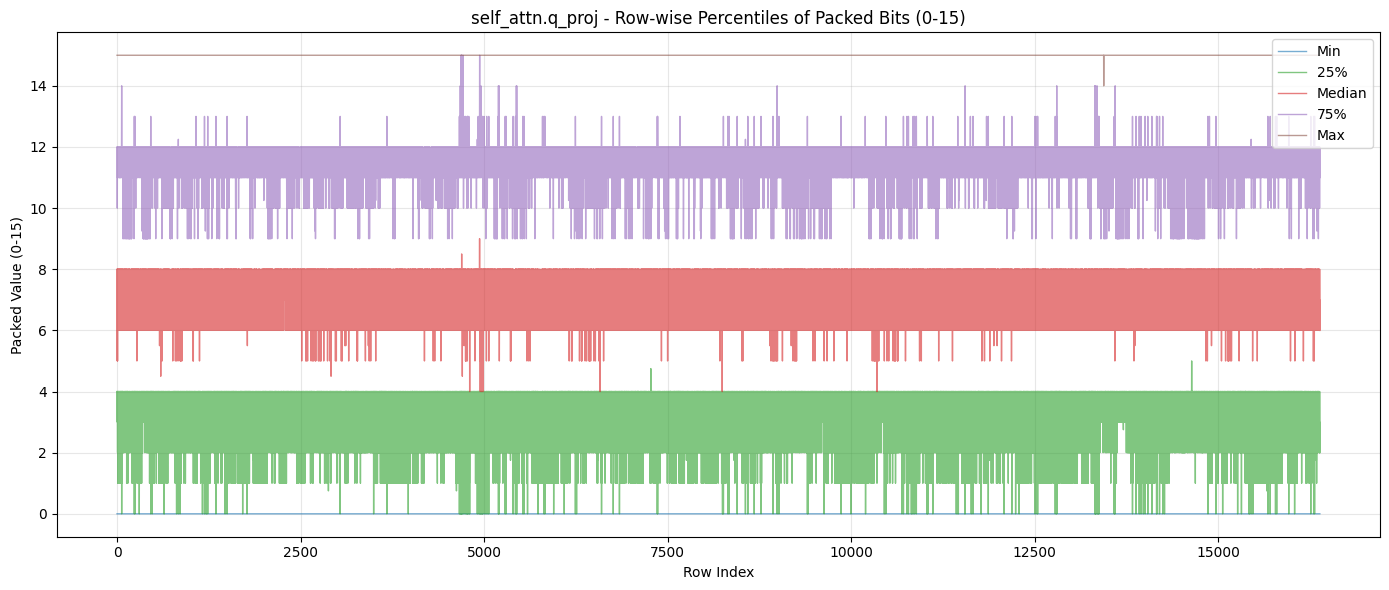

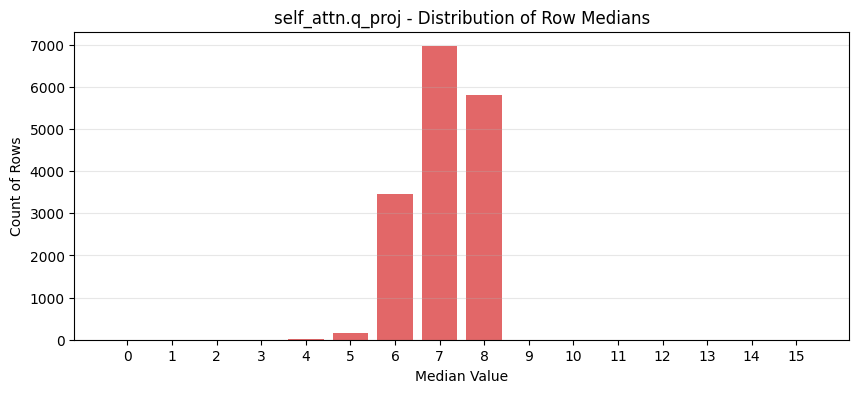

--- self_attn.k_proj ---


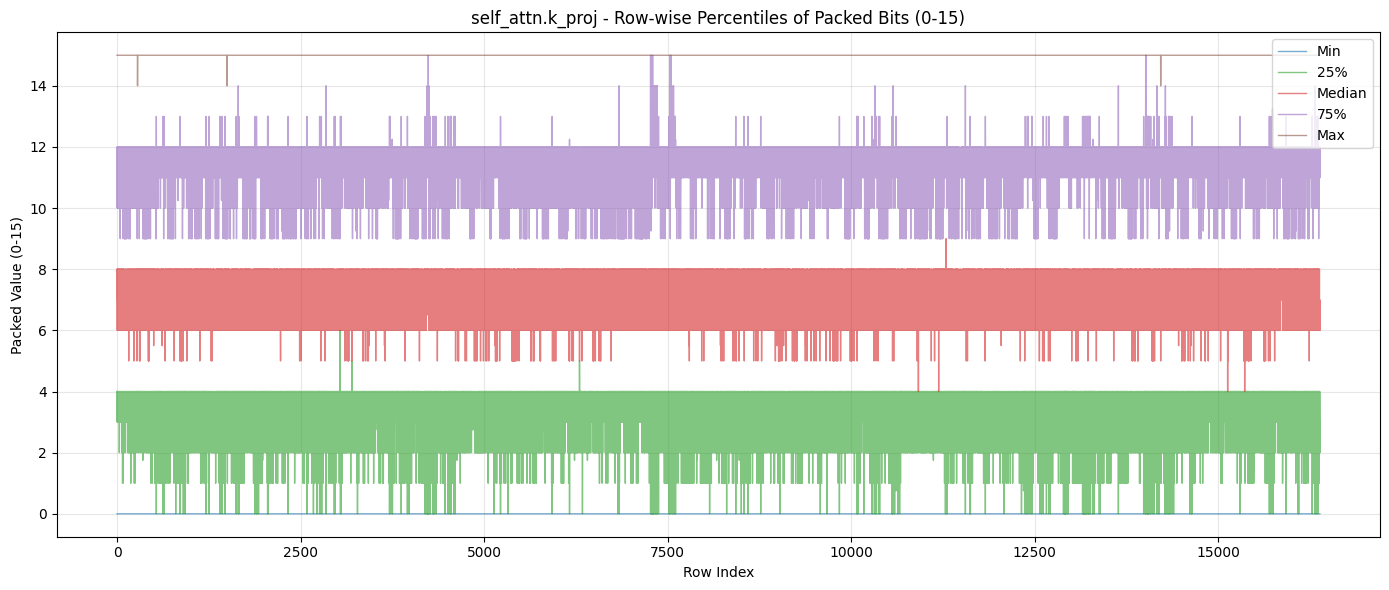

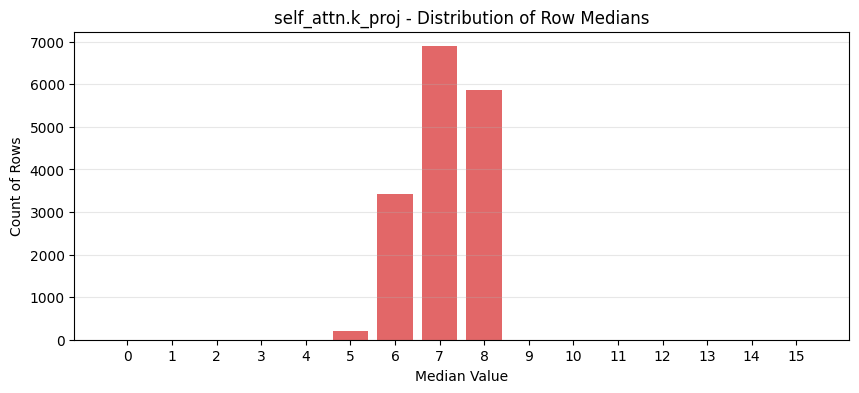

--- self_attn.v_proj ---


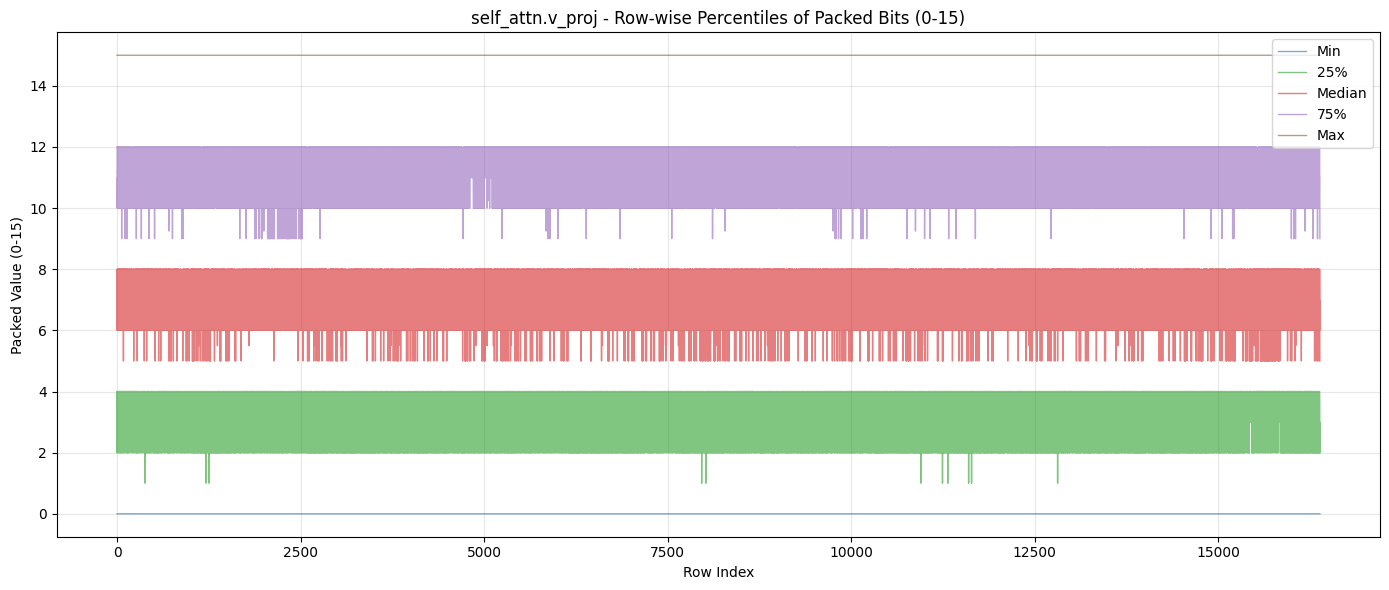

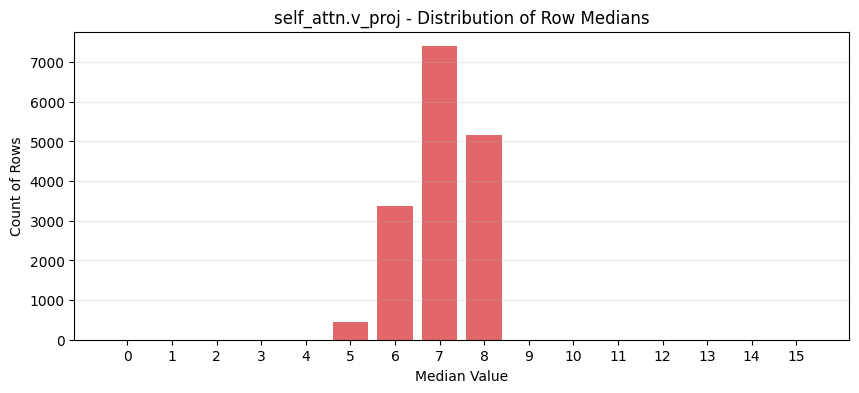

--- self_attn.o_proj ---


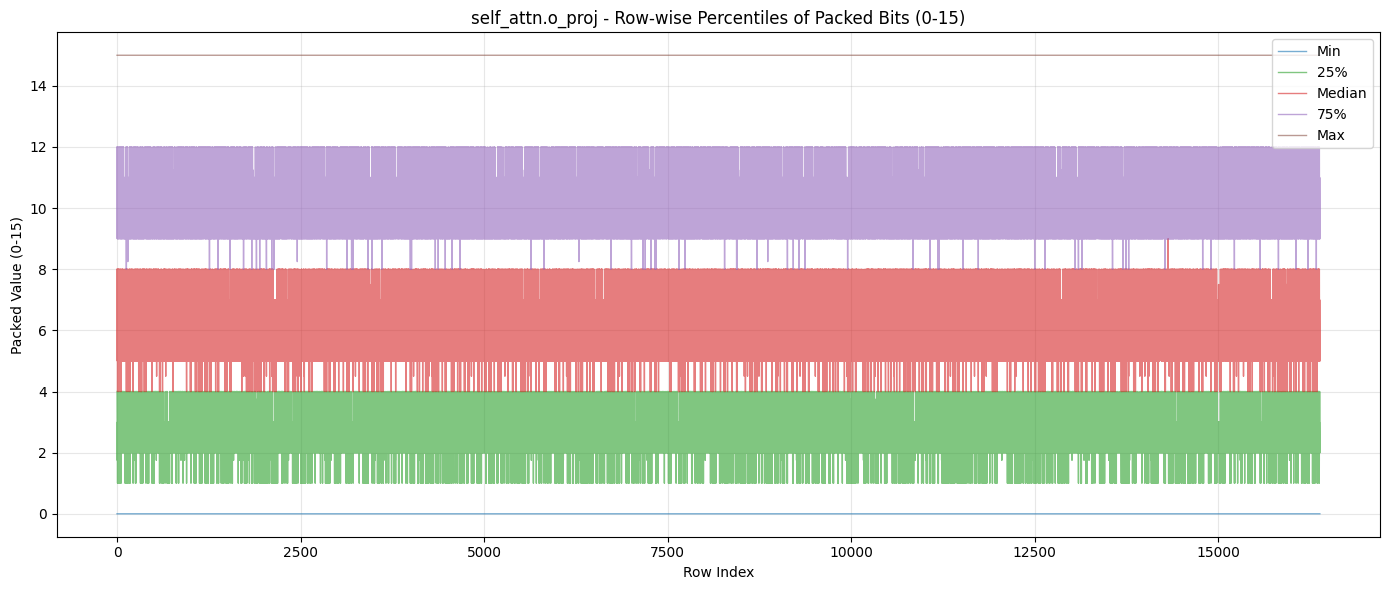

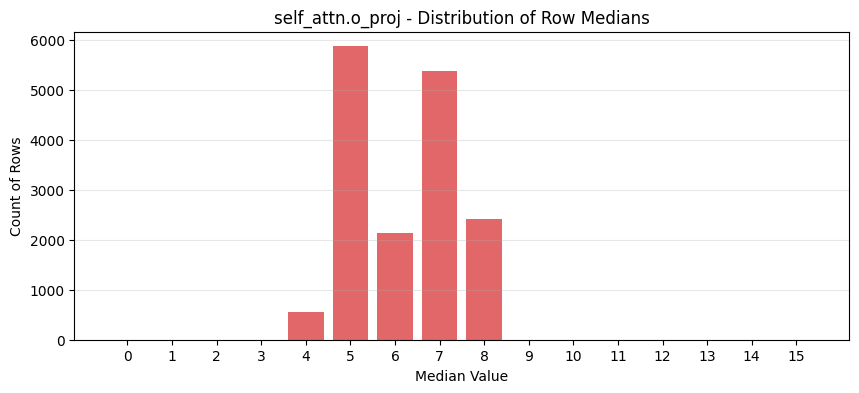

--- mlp.gate_proj ---


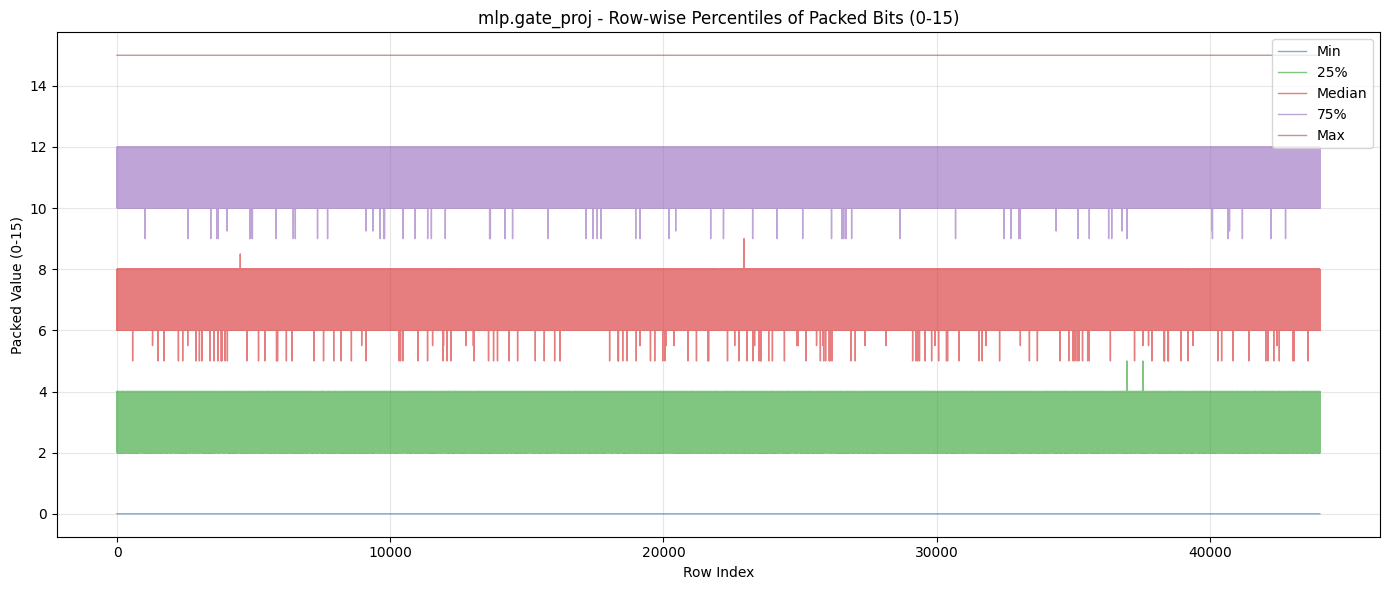

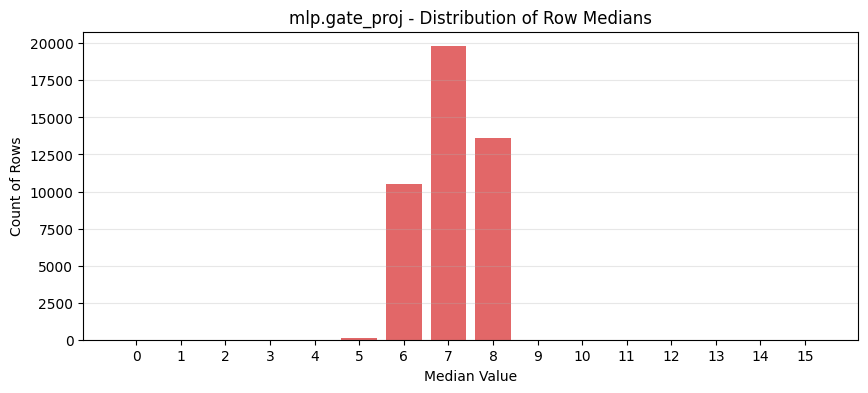

--- mlp.up_proj ---


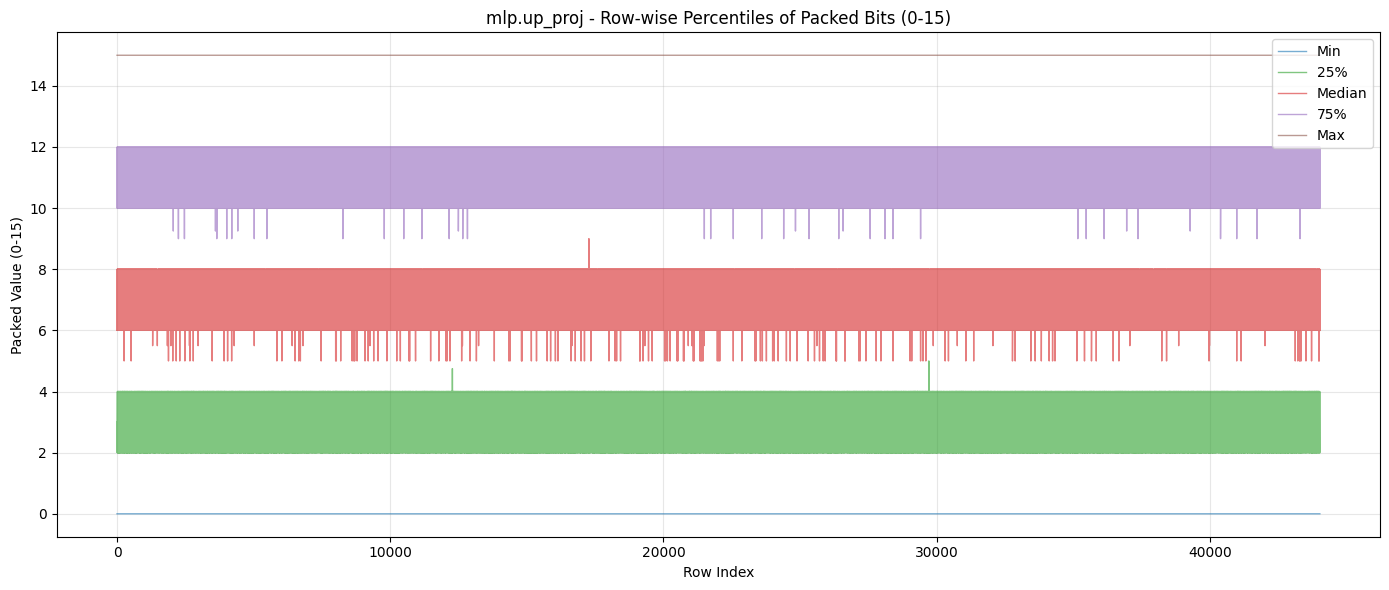

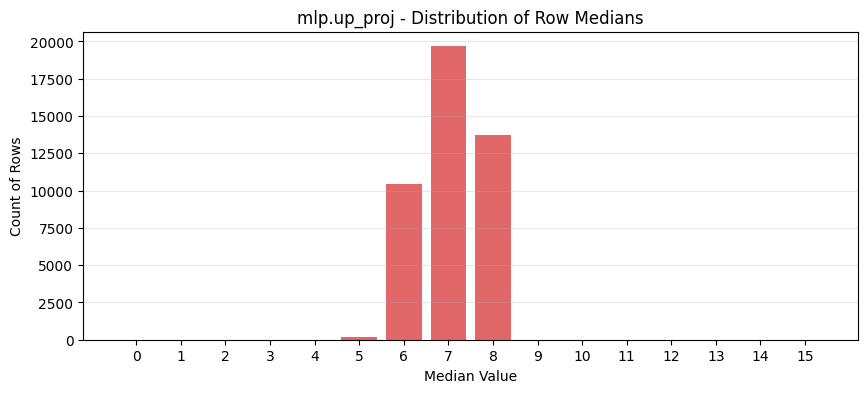

--- mlp.down_proj ---


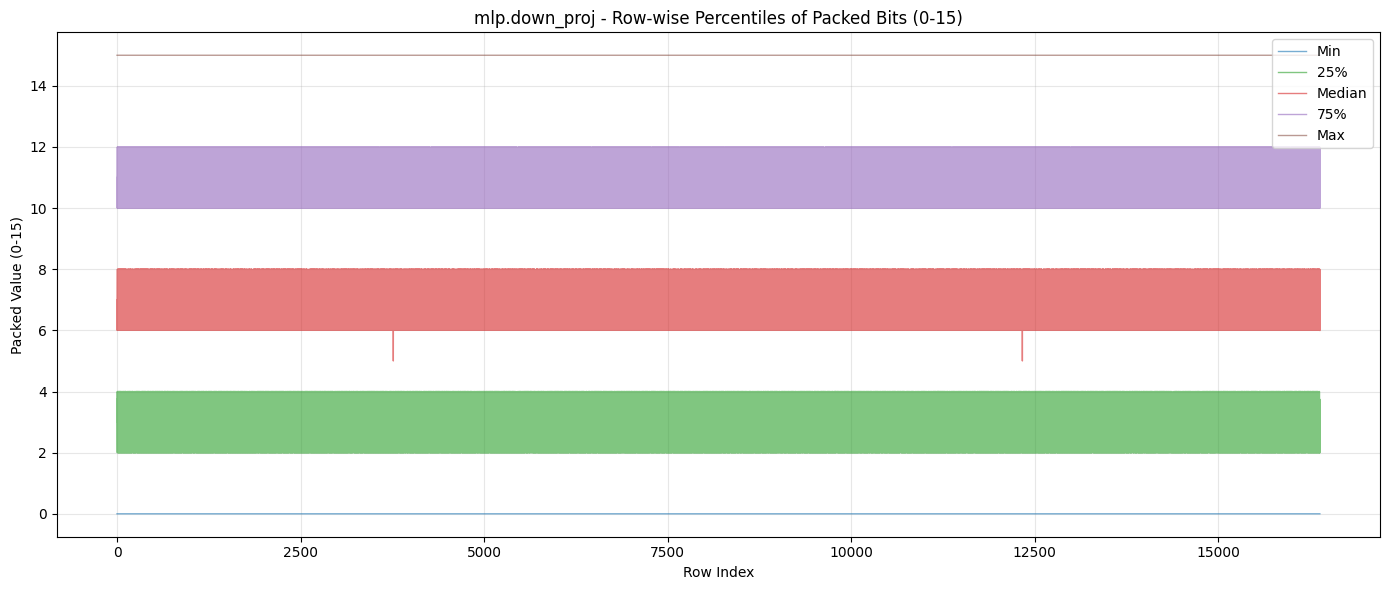

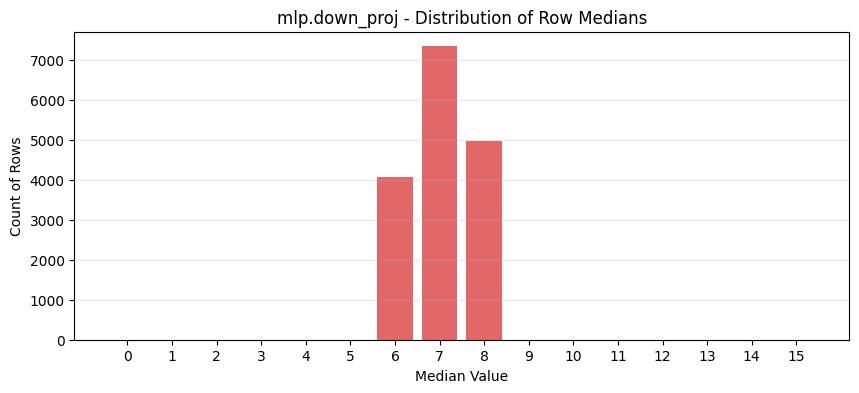

In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("Visualizing Row-wise Percentiles for Packed Bits...")

# Define percentiles to check
qs = [0, 0.25, 0.5, 0.75, 1.0]
q_labels = ['Min', '25%', 'Median', '75%', 'Max']
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b'] # distinct colors

for name, packed_bits in bit_weights_k_pack.items():
    print(f"--- {name} ---")
    
    # packed_bits shape: [rows, cols]
    # Convert to float for quantile calculation
    data_float = packed_bits.float()
    
    # Calculate quantiles for each row
    # Result shape: [len(qs), rows]
    # We use torch.quantile. Note: it requires float input.
    quantiles = torch.quantile(data_float, torch.tensor(qs, device=data_float.device), dim=1)
    
    quantiles_np = quantiles.cpu().numpy()
    num_rows = quantiles_np.shape[1]
    row_indices = np.arange(num_rows)
    
    # Plot 1: Percentiles across rows
    plt.figure(figsize=(14, 6))
    for i, q in enumerate(qs):
        # Plot with some transparency
        plt.plot(row_indices, quantiles_np[i], label=q_labels[i], color=colors[i], alpha=0.6, linewidth=1)
    
    plt.title(f"{name} - Row-wise Percentiles of Packed Bits (0-15)")
    plt.xlabel("Row Index")
    plt.ylabel("Packed Value (0-15)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Distribution of Medians (to see central tendency of rows)
    medians = quantiles_np[2] # 0.5 quantile
    plt.figure(figsize=(10, 4))
    plt.hist(medians, bins=np.arange(17)-0.5, rwidth=0.8, color=colors[2], alpha=0.7)
    plt.title(f"{name} - Distribution of Row Medians")
    plt.xlabel("Median Value")
    plt.ylabel("Count of Rows")
    plt.xticks(range(16))
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Visualizing Column-wise Distribution for Packed Bits...
--- Processing self_attn.q_proj ---
--- Processing self_attn.k_proj ---
--- Processing self_attn.v_proj ---
--- Processing self_attn.o_proj ---
--- Processing mlp.gate_proj ---
--- Processing mlp.up_proj ---
--- Processing mlp.down_proj ---


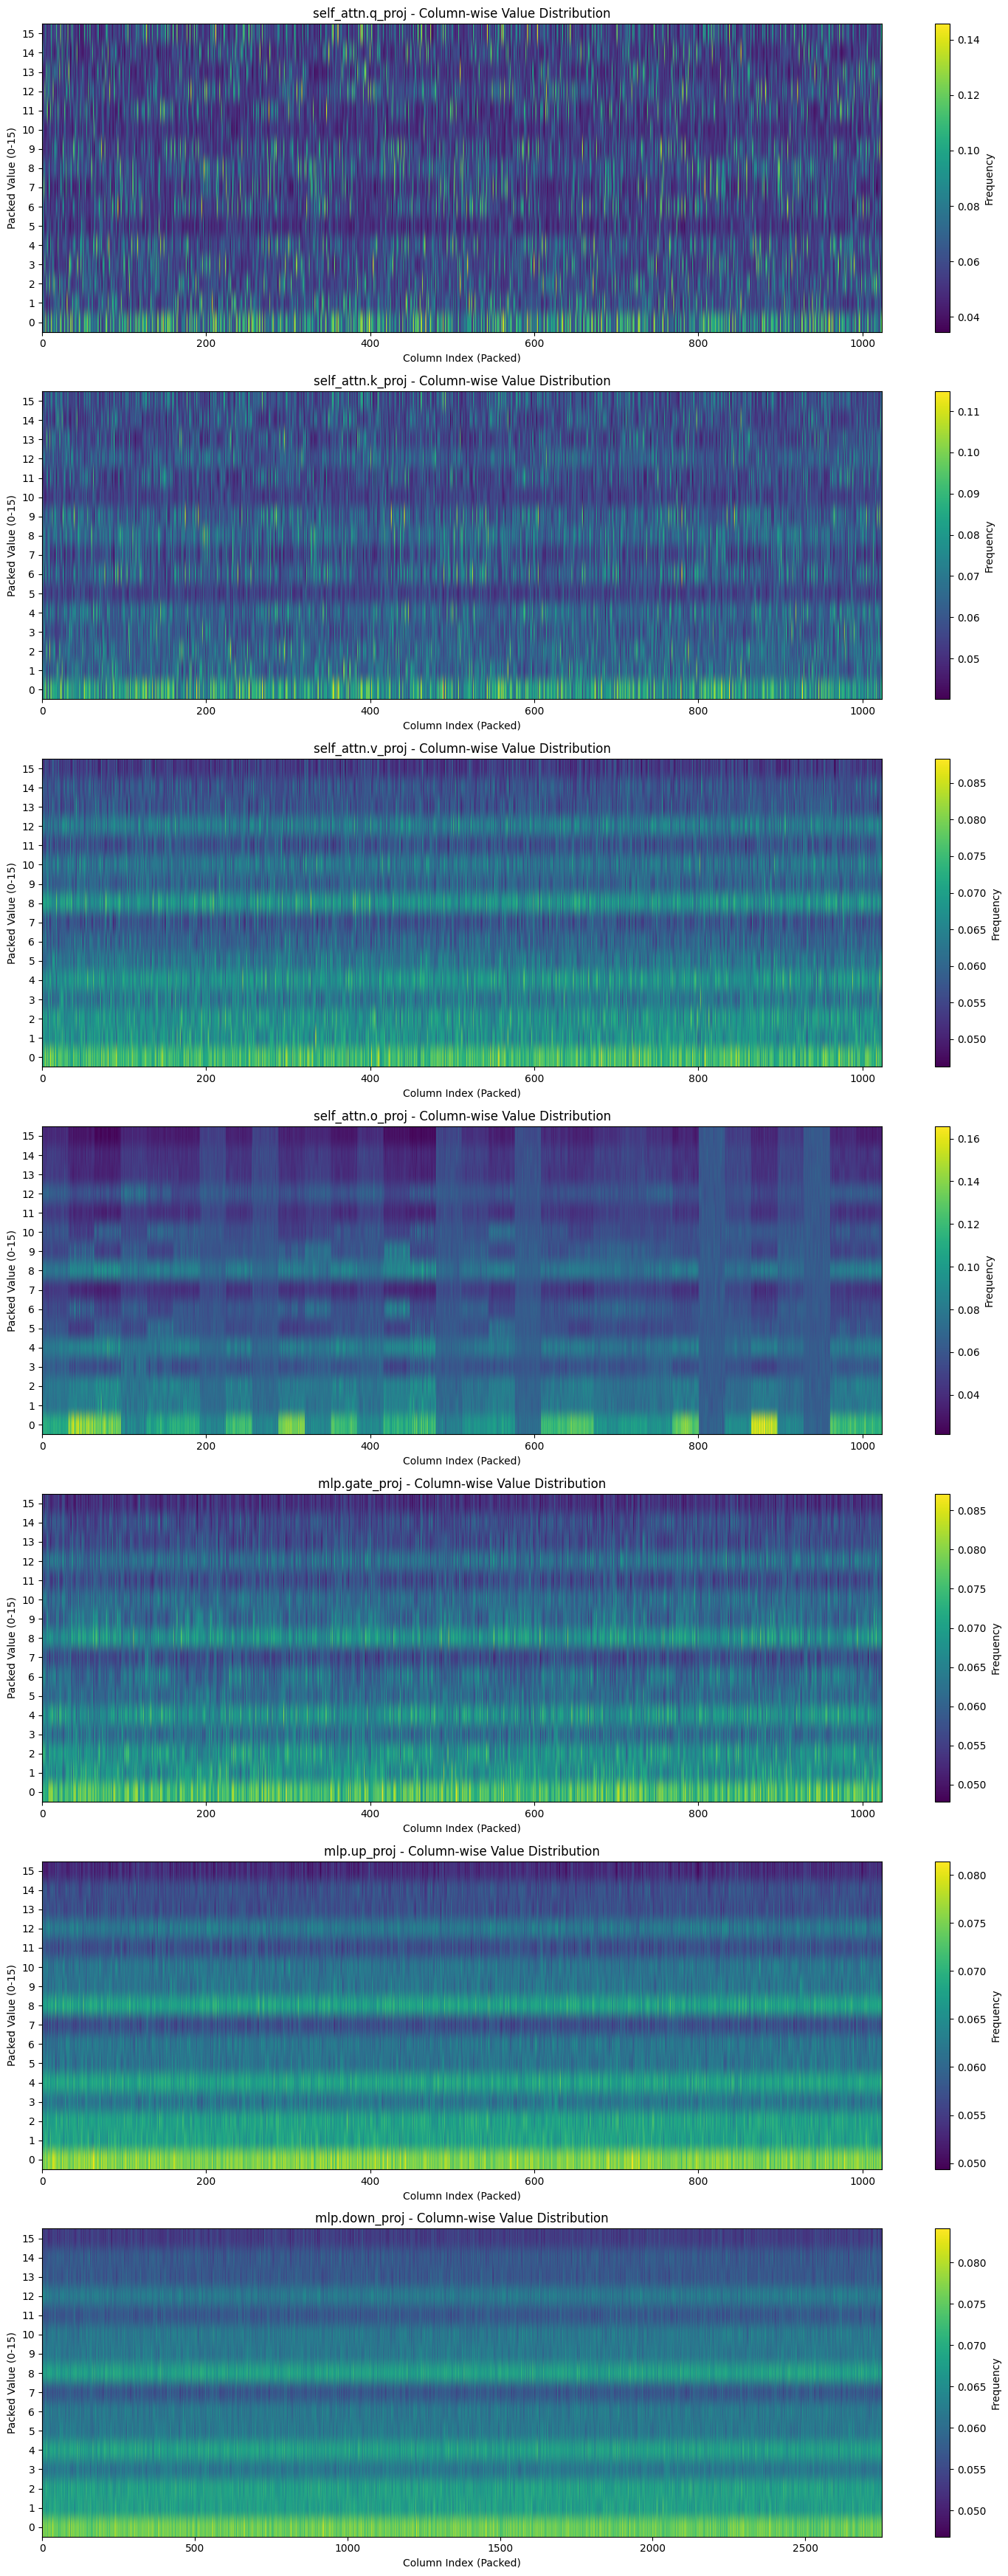

In [17]:
import math

print("Visualizing Column-wise Distribution for Packed Bits...")

items = list(bit_weights_k_pack.items())
num_items = len(items)

# Create subplots
fig, axes = plt.subplots(num_items, 1, figsize=(15, 5 * num_items))
if num_items == 1:
    axes = [axes]
# Ensure axes is iterable
if isinstance(axes, np.ndarray):
    axes = axes.flatten()

for i, (name, packed_bits) in enumerate(items):
    ax = axes[i]
    print(f"--- Processing {name} ---")
    
    # packed_bits shape: [rows, cols]
    rows, cols = packed_bits.shape
    
    # Move to CPU and ensure long type
    data = packed_bits.long().cpu()
    
    # Vectorized counting
    # Flatten data (row-major)
    flat_data = data.reshape(-1) # [rows * cols]
    
    # Create column indices corresponding to flat_data
    # data is row-major: row0, row1, ...
    # so col indices are: 0, 1, ..., cols-1, 0, 1, ..., cols-1
    col_indices = torch.arange(cols).repeat(rows)
    
    # Calculate flat indices for bincount
    # Index = col * 16 + value
    flat_indices = col_indices * 16 + flat_data
    
    # Bincount
    counts = torch.bincount(flat_indices, minlength=cols*16).reshape(cols, 16)
    
    # Transpose to [16, cols] for plotting (Y=Value, X=Column)
    # counts_t[val, col] = count of val in column col
    counts_t = counts.t().numpy()
    
    # Normalize to get probabilities for better visualization
    probs = counts_t / rows
    
    # Plot on subplot
    im = ax.imshow(probs, aspect='auto', cmap='viridis', origin='lower', extent=[0, cols, -0.5, 15.5])
    ax.set_title(f"{name} - Column-wise Value Distribution")
    ax.set_xlabel("Column Index (Packed)")
    ax.set_ylabel("Packed Value (0-15)")
    ax.set_yticks(range(16))
    fig.colorbar(im, ax=ax, label='Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#  name, module in targets.items():
#     print(f"--- Analyzing {name} ---")
#     w_int = get_int_weight(name, module)
#     if w_int is None:
#         continue
    
#     # w_int shape: [out_features, in_features] -> [rows, cols]
#     rows, cols = w_int.shape
#     print(f"Shape: {w_int.shape}")
    
#     # 1. Value Counts per Row
#     min_val = int(w_int.min().item())
#     max_val = int(w_int.max().item())
#     val_range = max_val - min_val + 1
#     print(f"Value range: {min_val} to {max_val}")
    
#     # Shift values to 0-based index
#     w_shifted = (w_int - min_val).long()
    
#     # Vectorized bincount for all rows
#     row_indices = torch.arange(rows).unsqueeze(1).expand(rows, cols).reshape(-1)
#     flat_values = w_shifted.reshape(-1)
    
#     flat_indices = row_indices * val_range + flat_values
#     counts = torch.bincount(flat_indices, minlength=rows*val_range).reshape(rows, val_range)
    
#     # Convert to numpy for plotting
#     counts_np = counts.numpy()
    
#     # Normalize to get probabilities/percentages
#     probs_np = counts_np / cols
    
#     # 2. Heatmap of Value Distribution
#     plt.figure(figsize=(12, 6))
#     # Plot heatmap
#     # X-axis: Integer Values
#     # Y-axis: Row Index
#     plt.imshow(probs_np, aspect='auto', cmap='viridis', interpolation='nearest', extent=[min_val, max_val+1, rows, 0])
#     plt.colorbar(label='Frequency')
#     plt.title(f"{name} - Value Distribution per Row")
#     plt.xlabel(f"Integer Value")
#     plt.ylabel("Row Index")
#     plt.show()
    
#     # 3. Concentration Analysis (Max Probability per Row)
#     max_probs = np.max(probs_np, axis=1)
    
#     plt.figure(figsize=(10, 4))
#     plt.hist(max_probs, bins=50)
#     plt.title(f"{name} - Max Concentration (Mode Frequency) per Row")
#     plt.xlabel("Frequency of Mode Value")
#     plt.ylabel("Count of Rows")
#     plt.show()
    
#     # 4. Mode Value Distribution
#     mode_indices = np.argmax(probs_np, axis=1)
#     mode_values = mode_indices + min_val
    
#     plt.figure(figsize=(10, 4))
#     plt.hist(mode_values, bins=np.arange(min_val, max_val+2)-0.5, rwidth=0.8)
#     plt.title(f"{name} - Mode Value Distribution")
#     plt.xlabel("Integer Value")
#     plt.ylabel("Count of Rows")
#     plt.xticks(np.arange(min_val, max_val+1))
#     plt.show()

Analyzing Layer 0 KV Cache (Int4)...


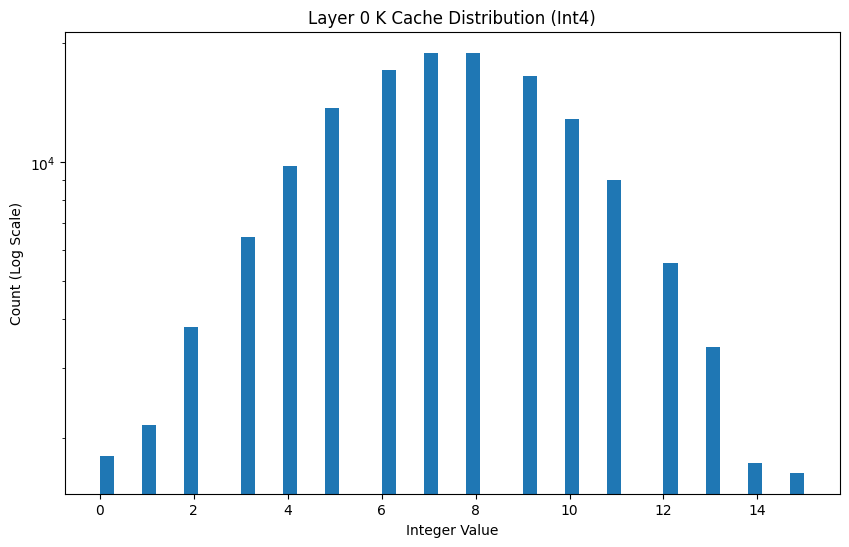

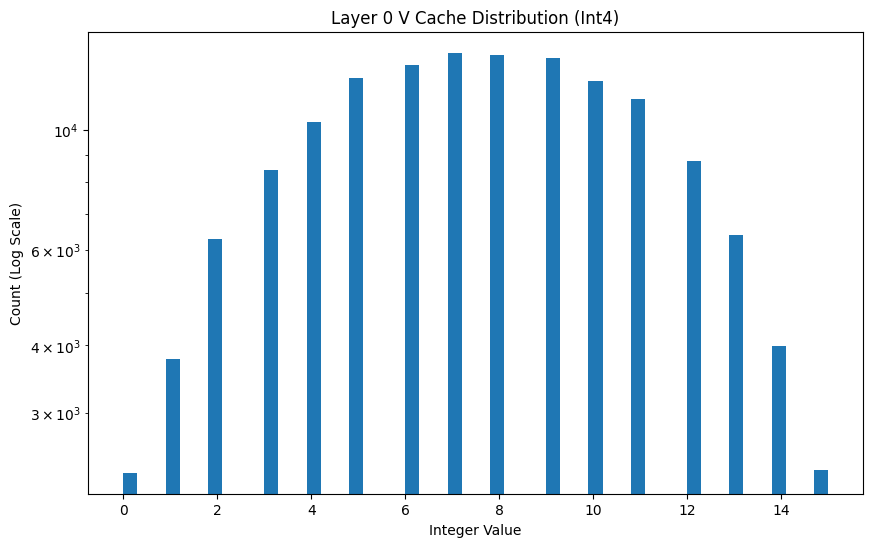

In [9]:
# Analyze KV Cache (Int4) for Layer 0
print("Analyzing Layer 0 KV Cache (Int4)...")

k_int_values = []
v_int_values = []

# Hooks
def k_quant_hook(module, input, output):
    # input is a tuple (x,), output is fake-quantized x
    # We want to quantize x to int
    # module is ActQuantizer
    x = input[0]
    # quantize returns (q, scale, zero) or (q, scale)
    res = module.quantize(x)
    q = res[0]
    k_int_values.append(q.detach().cpu().flatten().numpy())

def v_quant_hook(module, input, output):
    # module is ActQuantizer (out_quantizer of v_proj)
    # But wait, ActQuantWrapper calls out_quantizer(x)
    # So input to out_quantizer is x.
    x = input[0]
    res = module.quantize(x)
    q = res[0]
    v_int_values.append(q.detach().cpu().flatten().numpy())

# Register hooks
# K: apply_rotary_pos_emb_qk_rotation_wrapper.k_quantizer
k_quantizer = layer0.self_attn.apply_rotary_pos_emb_qk_rotation_wrapper.k_quantizer
h1 = k_quantizer.register_forward_hook(k_quant_hook)

# V: v_proj.out_quantizer
v_quantizer = layer0.self_attn.v_proj.out_quantizer
h2 = v_quantizer.register_forward_hook(v_quant_hook)

# Run Forward
text = "Hello, this is a test sentence to analyze the distribution of weights and kv cache. " * 2
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)

with torch.no_grad():
    model(input_ids)
    
h1.remove()
h2.remove()

# Plot K
if k_int_values:
    all_k = np.concatenate(k_int_values)
    plt.figure(figsize=(10, 6))
    plt.hist(all_k, bins=50, log=True)
    plt.title("Layer 0 K Cache Distribution (Int4)")
    plt.xlabel("Integer Value")
    plt.ylabel("Count (Log Scale)")
    plt.show()
else:
    print("No K cache captured.")

# Plot V
if v_int_values:
    all_v = np.concatenate(v_int_values)
    plt.figure(figsize=(10, 6))
    plt.hist(all_v, bins=50, log=True)
    plt.title("Layer 0 V Cache Distribution (Int4)")
    plt.xlabel("Integer Value")
    plt.ylabel("Count (Log Scale)")
    plt.show()
else:
    print("No V cache captured.")